In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ANN learning libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import scipy.stats as si
from scipy.stats import norm
from functools import partial
from scipy.optimize import minimize


In [20]:
import pandas as pd

data = pd.read_csv("Data_heston_rstparm2.txt", header=None)
#data headings [v0, kapa, theta, sigma, rho, imp vol 1-36]
 data


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.068883,9.1521,0.042540,0.73936,0.179420,0.23481,0.21965,0.21285,0.20933,0.20739,...,0.22651,0.22220,0.21936,0.21738,0.26442,0.24513,0.23501,0.22883,0.22473,0.22184
1,0.029457,9.7353,0.059143,0.43976,0.280170,0.22166,0.22552,0.22846,0.23072,0.23245,...,0.24586,0.24542,0.24514,0.24494,0.25656,0.25243,0.25017,0.24880,0.24790,0.24727
2,0.065464,7.6882,0.047845,0.55883,-0.097288,0.26079,0.24577,0.23793,0.23323,0.23018,...,0.22194,0.22039,0.21953,0.21901,0.23983,0.22984,0.22483,0.22219,0.22067,0.21975
3,0.062363,1.2865,0.045538,0.13232,-0.141720,0.25456,0.24941,0.24511,0.24147,0.23839,...,0.23093,0.22838,0.22629,0.22458,0.23936,0.23518,0.23176,0.22897,0.22669,0.22482
4,0.069407,7.2535,0.046342,0.76516,-0.179330,0.28558,0.26301,0.25059,0.24274,0.23744,...,0.21596,0.21383,0.21275,0.21219,0.24022,0.22807,0.22069,0.21672,0.21448,0.21318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116708,0.044382,5.4043,0.056927,0.60656,0.203020,0.24379,0.23576,0.23203,0.23044,0.22991,...,0.24979,0.24738,0.24580,0.24471,0.27896,0.26692,0.26001,0.25553,0.25249,0.25032
116709,0.073534,8.7358,0.059345,0.79486,-0.183030,0.29404,0.27687,0.26757,0.26191,0.25819,...,0.23918,0.23867,0.23860,0.23869,0.25429,0.24501,0.24112,0.23947,0.23877,0.23851
116710,0.063248,8.6890,0.050015,0.63263,0.078542,0.24814,0.23613,0.23072,0.22788,0.22627,...,0.23327,0.23089,0.22940,0.22839,0.25785,0.24515,0.23865,0.23488,0.23250,0.23088
116711,0.071833,5.9051,0.059103,0.43902,0.053994,0.26408,0.25521,0.25066,0.24813,0.24662,...,0.25144,0.24943,0.24815,0.24728,0.26993,0.26057,0.25545,0.25240,0.25045,0.24912


In [21]:
# define inputs and targets
targets = data.iloc[:, 0:5]
data = data.iloc[:, 5:]

In [107]:
# split data into training and test sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.3, shuffle=True, random_state=123)

In [108]:
# store test inputs for results
pd.DataFrame(test_inputs).to_csv("test_inputsHestparam.csv")


In [109]:
# Scale inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [110]:
# convert to tensor
train_inputs = tf.convert_to_tensor(train_inputs, dtype='float64')
train_targets = tf.convert_to_tensor(train_targets.values, dtype='float64')
test_inputs = tf.convert_to_tensor(test_inputs, dtype='float64')
test_targets = tf.convert_to_tensor(test_targets.values, dtype='float64')


36

In [112]:
# Define the model
input_size = train_inputs.shape[1]
output_size = 5

hidden_layer_size = 250

model = tf.keras.Sequential([
   tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu),  # 1st hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu),  # 2nd Hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu),  # 3rd Hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu), # 4th Hidden layer
    tf.keras.layers.Dense(
        hidden_layer_size, activation=tf.nn.relu), # 5th Hidden layer

    tf.keras.layers.Dense(output_size, activation="linear")  # output layer

])


In [113]:
# set an early stopping mechanism
LRScheduler = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10,
                                verbose=1, min_delta=0.00001, cooldown=10, min_lr=0.000001)


In [117]:
# define customized loss function
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    #squared_difference = squared_difference * [10, 0.0045, 40, 0.45, 2]
    squared_difference = squared_difference * [10/52.4545, 0.0045/52.4545, 40/52.4545, 0.45/52.4545, 2/52.4545]
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1

In [123]:
# begin training
adam = Adam(learning_rate=7e-03)
model.compile(optimizer=adam, loss=my_loss_fn, metrics=["mean_absolute_error"])

batch_size = 45

max_epochs = 1000

history = model.fit(train_inputs,  
                    train_targets,  
                    batch_size=batch_size,  
                    # epochs that we will train for (assuming early stopping doesn't kick in)
                    epochs=max_epochs,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=True, min_delta=0),
                        LRScheduler
                    ],
                    verbose=True)


Epoch 1/1000
1634/1634 [==============================] - 8s 4ms/step - loss: 3.8017e-06 - mean_absolute_error: 0.0510 - val_loss: 2.3985e-06 - val_mean_absolute_error: 0.0501
Epoch 2/1000
1634/1634 [==============================] - 8s 5ms/step - loss: 3.3361e-06 - mean_absolute_error: 0.0481 - val_loss: 5.1370e-06 - val_mean_absolute_error: 0.0633
Epoch 3/1000
1634/1634 [==============================] - 8s 5ms/step - loss: 3.5019e-06 - mean_absolute_error: 0.0496 - val_loss: 3.0822e-06 - val_mean_absolute_error: 0.0456
Epoch 4/1000
1634/1634 [==============================] - 8s 5ms/step - loss: 3.4459e-06 - mean_absolute_error: 0.0489 - val_loss: 4.0914e-06 - val_mean_absolute_error: 0.0549
Epoch 5/1000
1634/1634 [==============================] - 8s 5ms/step - loss: 3.5512e-06 - mean_absolute_error: 0.0498 - val_loss: 4.7033e-06 - val_mean_absolute_error: 0.0587
Epoch 6/1000
1634/1634 [==============================] - 8s 5ms/step - loss: 3.5323e-06 - mean_absolute_error: 0.0499 -

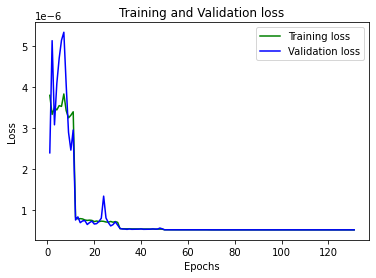

In [127]:
# plot mse train and validation across epochs
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(history.epoch)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


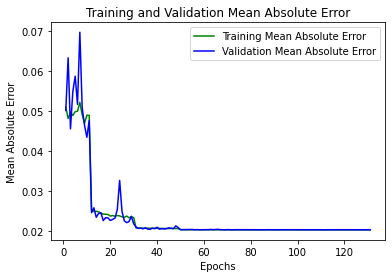

In [128]:
# plot mae train and validation across epochs
loss_train = history.history["mean_absolute_error"]
loss_val = history.history["val_mean_absolute_error"]
epochs = range(1, len(history.epoch)+1)
plt.plot(epochs, loss_train, 'g', label='Training Mean Absolute Error')
plt.plot(epochs, loss_val, 'b', label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [129]:
# save model
model_dir = 'paramHestModel.h5'
model.save(model_dir)

In [131]:
# load model
from tensorflow.keras.models import load_model, save_model
calibration_model = tf.keras.models.load_model("paramHestModel.h5",custom_objects={ 'my_loss_fn': my_loss_fn } )

In [133]:
# time pre-trained model on 1000 samples
import time
start = time.time()

s = (1000, output_size)
y_pred = np.zeros(s)
for i in range(1000):
    X_try = test_inputs[i, :]
    c = np.array([X_try])
    y_pred[i, :] = calibration_model.predict(c)

end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

pd.DataFrame(y_pred).to_csv("Hest_param_pred.csv")


Runtime of the program is 29.930181980133057


In [134]:
# save true targets
test_targets = test_targets.numpy()
test_targets_sub = test_targets[0:999, :]

test_targets_sub
pd.DataFrame(test_targets_sub).to_csv("Hest_param_true.csv")
